In [1]:
import torch
import torch.nn as nn
import numpy as np
from time import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import scipy.io as sio
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch.utils.data import DataLoader
from utils.datasets import video_loader, mario_loader, image_loader
from utils.model import Layer_FISTA
from utils.model import Shrinkage_Layer

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from utils.compare import AE, WTA_RNN_AE

import cv2

# Mario Dataset

In [2]:
# loader = DataLoader(mario_loader('data/mario_video_test.npy'), batch_size=1, shuffle=False, num_workers=1)
vid_loader = DataLoader(mario_loader("data/mario_video_test.npy"), batch_size=1, shuffle=False)
labels = [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100 + [4] * 100

In [3]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.completeness_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=500,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.4f}\t{:.4f}\t{:.4f}"#\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return results

def compute_scores(U, dim, labels):
    U = U[0].cpu().numpy()
    # print(U.shape)
    U = np.mean(np.abs(U), axis=1)

    U_flat = np.zeros((U.shape[-1], U.shape[0] * U.shape[1]))
    for i in range(U.shape[-1]):
        U_flat[i, :] = U[:,:,:,i].flatten()
    #print(U_flat.shape)

    pca = PCA(n_components=dim)
    U_new_F_PCA = pca.fit_transform(U_flat)
    kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
    
    result = bench_k_means(kmeans=kmeans, name="k-means++", data=U_new_F_PCA, labels=labels)
    return result


# WTA RNN AE

In [12]:
wta_ae = WTA_RNN_AE(32*32*3, 10)
wta_ae.to(device)
wta_ae.load_state_dict(torch.load('runs/WTA_AE/mario/trained_autoencoder.pth'))
# loader = DataLoader(mario_loader("data/mario_video_test.npy"), batch_size=1, shuffle=False)
video_WTA = []
video_gt = []
with torch.inference_mode():
    for batch in vid_loader:
        batch = batch.to(torch.float32).to(device)
        video = []
        gt = []
        for i in range(batch.shape[-1]):
            img_batch = batch[:, :, :, :, i].clone()
            # next_img_batch = batch[:, :, :, :, i+1].clone()
            if i == 0: h = None
            img_batch = img_batch.reshape(-1, 32*32*3)#.to(device)
            # Forward pass
            recon, pred, h = wta_ae(img_batch, h)
            video.append(recon.cpu().numpy())
            gt.append(img_batch.reshape(-1,32*32*3).cpu().numpy())
        video = np.array(video)
        video_WTA.append(video)
        video_gt.append(np.array(gt))
        #break
        

In [5]:
len(video_WTA)

5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


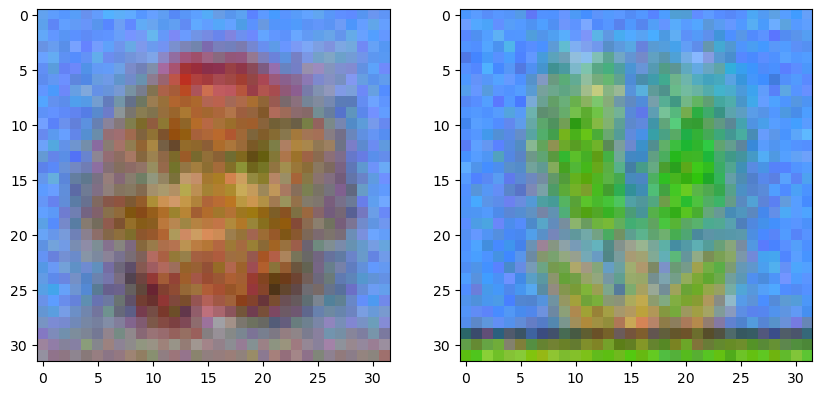

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(video_WTA[0][300].reshape(3, 32, 32).transpose(1, 2, 0), cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(video_WTA[0][400].reshape(3, 32, 32).transpose(1, 2, 0), cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
encode_list_WTA = []
with torch.inference_mode():
    for batch in vid_loader:
        batch = batch.to(torch.float32).to(device)
        video_encode = []
        for i in range(batch.shape[-1]):
            img_batch = batch[:, :, :, :, i].clone()
            # next_img_batch = batch[:, :, :, :, i+1].clone()
            if i == 0: h = None
            img_batch = img_batch.reshape(-1, 32*32*3)#.to(device)
            # Forward pass
            code = wta_ae.encoder(img_batch)
            video_encode.append(code.cpu().numpy())
        print(len(video_encode))
        encode_list_WTA.append(np.vstack(video_encode))
        

500
500
500
500
500


In [8]:
encode_list_WTA[0].shape

(500, 64)

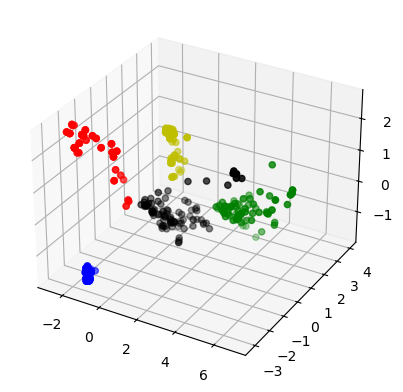

In [9]:
pca = PCA(n_components=3)
test = pca.fit_transform(encode_list_WTA[0])
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(test[:100,0], test[:100,1], test[:100,2], c='g', marker='o')
ax.scatter(test[100:200,0], test[100:200,1], test[100:200,2], c='y', marker='o')
ax.scatter(test[200:300,0], test[200:300,1], test[200:300,2], c='b', marker='o')
ax.scatter(test[300:400,0], test[300:400,1], test[300:400,2], c='k', marker='o')
ax.scatter(test[400:500,0], test[400:500,1], test[400:500,2], c='r', marker='o')
plt.show()

In [10]:
acc_WTA_AE, ari_WTA_AE = [], []
print("init\t\ttime\tinertia\tcompl\tARI\tss")
for i in range(5):
    result_AE = compute_scores(torch.from_numpy(encode_list_WTA[i].T[None,None,None,:,None,:]), 3, labels)
    acc_WTA_AE.append(result_AE[-3])
    ari_WTA_AE.append(result_AE[-2])
    
print('WTA-AE ACC:', np.mean(acc_WTA_AE))
print('WTA-AE ARI:', np.mean(ari_WTA_AE))

init		time	inertia	compl	ARI	ss
k-means++	0.105s	105	0.9685	0.9660	0.7730
k-means++	0.036s	168	0.8680	0.8044	0.6556
k-means++	0.027s	105	0.9833	0.9851	0.7841
k-means++	0.027s	165	0.8376	0.6703	0.6234
k-means++	0.027s	64	0.9809	0.9851	0.8058
WTA-AE ACC: 0.927634167728147
WTA-AE ARI: 0.8821914916407356


# AE

In [11]:
ae = AE(3*32*32)
ae.to(device)
ae.load_state_dict(torch.load('runs/AE/mario/trained_autoencoder.pth'))

video_ae = []
with torch.inference_mode():
    for i, vid in enumerate(vid_loader):
        vid = vid.to(device)
        print(vid.shape)
        video = []
        for j in range(vid.shape[-1]):
            
            img = vid[0,:,:,:,j].to(torch.float32).to(device).view(-1, 3*32*32)
            output = ae(img)
            video.append(output.cpu().detach().numpy())
        video_ae.append(np.array(video))
        #break

torch.Size([1, 3, 32, 32, 500])
torch.Size([1, 3, 32, 32, 500])
torch.Size([1, 3, 32, 32, 500])
torch.Size([1, 3, 32, 32, 500])
torch.Size([1, 3, 32, 32, 500])


In [12]:
len(video_ae)

5

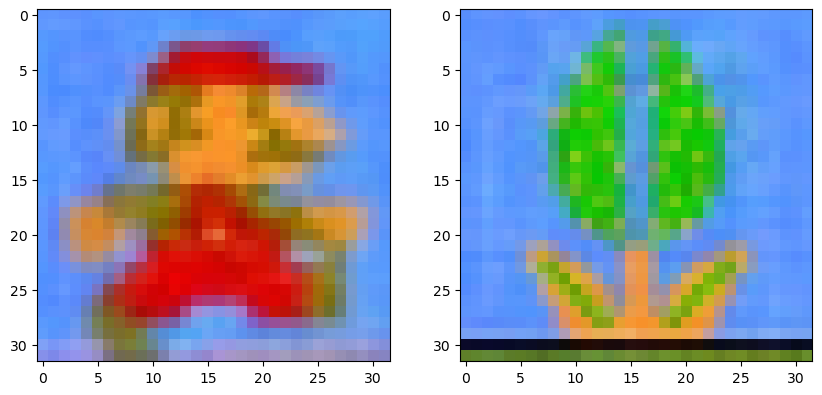

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(video_ae[0][340].reshape(3, 32, 32).transpose(1, 2, 0), cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(video_ae[0][400].reshape(3, 32, 32).transpose(1, 2, 0), cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
encode_list_ae = []
with torch.inference_mode():
    for i, vid in enumerate(vid_loader):
        vid = vid.to(device)
        print(vid.shape)
        vid_encode = []
        for j in range(vid.shape[-1]):
            
            img = vid[0,:,:,:,j].to(torch.float32).to(device).view(-1, 3*32*32)
            output = ae.encoder(img)
            vid_encode.append(output.squeeze().cpu().detach().numpy())
        encode_list_ae.append(np.array(vid_encode))
        

torch.Size([1, 3, 32, 32, 500])
torch.Size([1, 3, 32, 32, 500])
torch.Size([1, 3, 32, 32, 500])
torch.Size([1, 3, 32, 32, 500])
torch.Size([1, 3, 32, 32, 500])


In [15]:
acc_AE, ari_AE = [], []
print("init\t\ttime\tinertia\tcompl\tARI\tss")
for i in range(5):
    result_AE = compute_scores(torch.from_numpy(encode_list_ae[i].T[None,None,None,:,None,:]), 3, labels)
    acc_AE.append(result_AE[-3])
    ari_AE.append(result_AE[-2])
    
print('AE ACC:', np.mean(acc_AE))
print('AE ARI:', np.mean(ari_AE))

init		time	inertia	compl	ARI	ss
k-means++	0.028s	222	0.9150	0.7267	0.6341
k-means++	0.090s	246	0.7019	0.6018	0.5245


k-means++	0.120s	251	0.9348	0.9395	0.4905
k-means++	0.095s	311	0.7312	0.6084	0.4179
k-means++	0.073s	167	0.9579	0.9607	0.5833
AE ACC: 0.8481465006480216
AE ARI: 0.7674113723939235


In [16]:
encode_list_ae[0].shape

(500, 9)

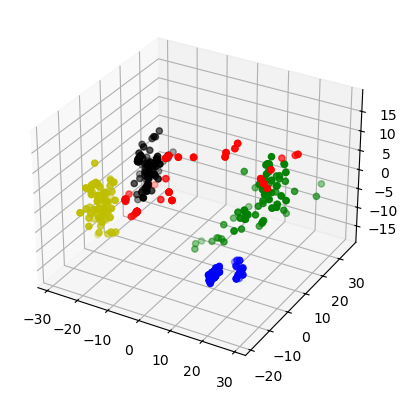

In [17]:
pca = PCA(n_components=3)
test = pca.fit_transform(encode_list_ae[0])
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(test[:100,0], test[:100,1], test[:100,2], c='g', marker='o')
ax.scatter(test[100:200,0], test[100:200,1], test[100:200,2], c='y', marker='o')
ax.scatter(test[200:300,0], test[200:300,1], test[200:300,2], c='b', marker='o')
ax.scatter(test[300:400,0], test[300:400,1], test[300:400,2], c='k', marker='o')
ax.scatter(test[400:500,0], test[400:500,1], test[400:500,2], c='r', marker='o')
plt.show()

In [18]:
encode_list_ae[0].T[None,None,None,:,None,:].shape

(1, 1, 1, 9, 1, 500)

In [19]:
acc_AE, ari_AE = [], []
print("init\t\ttime\tinertia\tcompl\tARI\tss")
for i in range(5):
    result_AE = compute_scores(torch.from_numpy(encode_list_ae[i].T[None,None,None,:,None,:]), 3, labels)
    acc_AE.append(result_AE[-3])
    ari_AE.append(result_AE[-2])
    
print('AE ACC:', np.mean(acc_AE))
print('AE ARI:', np.mean(ari_AE))

init		time	inertia	compl	ARI	ss
k-means++	0.031s	222	0.9150	0.7267	0.6341
k-means++	0.120s	246	0.7019	0.6018	0.5245


k-means++	0.115s	251	0.9348	0.9395	0.4905
k-means++	0.112s	311	0.7312	0.6084	0.4179
k-means++	0.047s	167	0.9579	0.9607	0.5833
AE ACC: 0.8481465006480216
AE ARI: 0.7674113723939235


# DPCN-FISTA + DCPN-Shrinkage

In [5]:
FISTA = Layer_FISTA(n_ch=3, lam=0.5, gamma0=1., mu=0.01/150, beta=0.5, X_dim=300, U_dim=40, patch_size=16, 
                     input_size=40, isTopLayer=True, n_steps=50)
FISTA.to(device)
FISTA.load_state_dict(torch.load('runs/FISTA/mario/layer1.pth.tar'))
FISTA.eval()

Layer_FISTA()

In [6]:
from utils.model import Shrinkage_Layer

In [22]:
#Shrinkage = Shrinkage_Layer_Mario(n_ch=3, lam=.5, gamma0=0.3, mu=0.3, beta=0.5, n_u=100)
Shrinkage = Shrinkage_Layer(n_ch=3, lam=.5, gamma0=0.3, mu=0.3, beta=0.5, n_x=1, n_u=100, multi_dict=False, use_A=True)
Shrinkage.to(device)
Shrinkage.load_state_dict(torch.load('runs/shrinkage/mario/layer1.pth.tar'))
Shrinkage.eval()

Shrinkage_Layer()

In [23]:
acc_F, acc_S = [], []
ari_F, ari_S = [], []
spa_F, spa_S = [], []
video_FISTA = []
encode_list_FISTA = []
encode_list_Shrinkage = []
with torch.no_grad():
    for _, data in enumerate(vid_loader):
        data = data.to(torch.float32).to(device)
        start = time()
        X_F, U_F = FISTA.inference(data)
        print("FISTA Inference Time:", time()-start)
        x_t_minus_1 = torch.randn_like(X_F[:, :, :, :, :, 0])
        video_recon_F, _, _ = FISTA(X_F, U_F, x_t_minus_1)
        
        start = time()
        X_S, U_S = Shrinkage.inference(data)
        print("Shrinkage Inference Time:", time()-start)
        x_t_minus_1 = torch.randn_like(X_S[:, :, :, :, :, 0])
        video_recon_S, _, _ = Shrinkage(X_S, U_S, x_t_minus_1)
        
        encode_list_FISTA.append(U_F.cpu().numpy())
        encode_list_Shrinkage.append(U_S.cpu().numpy())
        
        video_FISTA.append(video_recon_F.cpu().numpy())
        #video_Shinkage.append(video_recon_S.cpu().numpy())
        
        print("init\t\ttime\tinertia\tcompl\tARI\tss")
        result_F = compute_scores(U_F, 2, labels)
        result_S = compute_scores(U_S, 2, labels)
        print()
        
        acc_F.append(result_F[-3])
        
        acc_S.append(result_S[-3])
        
        ari_F.append(result_F[-2])
        ari_S.append(result_S[-2])
        
        spa_F.append(np.sum(U_F.cpu().numpy() == 0) / U_F.cpu().numpy().size)
        spa_S.append(np.sum(U_S.cpu().numpy() == 0) / U_S.cpu().numpy().size)
        
print("FISTA ACC:", np.mean(acc_F), "FISTA ARI:", np.mean(ari_F), "FISTA Sparsity:", np.mean(spa_F))
print("Shrinkage ACC:", np.mean(acc_S), "Shrinkage ARI:", np.mean(ari_S), "Shrinkage Sparsity:", np.mean(spa_S))

	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
FISTA Inference Time: 42.44937992095947
	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
Shrinkage Inference Time: 7.765340089797974
init		time	inertia	compl	ARI	ss
k-means++	0.004s	10	0.8875	0.8685	0.6638
k-means++	0.003s	12	0.9722	0.9800	0.8694

	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
FISTA Inference Time: 42.26072573661804
	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
Shrinkage Inference Time: 7.7434844970703125
init		time	inertia	compl	ARI	ss
k-means++	0.004s	17	0.8707	0.6861	0.7957
k-means++	0.003s	10	0.9276	0.9331	0.7845

	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
FISTA Inference Time: 42.2329158782959
	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
Shrinkage Inference Time: 7.751846075057983
init		time	inertia	compl	ARI	ss
k-means++	0.004s	11	0.8852	0.6980	0.6578
k-means++	0.003s	8	0.9722	0.9753	0.9010

	 100 frame
	 200 frame
	 300 frame
	 400 fr

In [24]:
print("FISTA ACC:", np.mean(acc_F), "FISTA ARI:", np.mean(ari_F), "FISTA Sparsity:", np.mean(spa_F))
print("Shrinkage ACC:", np.mean(acc_S), "Shrinkage ARI:", np.mean(ari_S), "Shrinkage Sparsity:", np.mean(spa_S))

FISTA ACC: 0.8874500221524231 FISTA ARI: 0.7372214200343019 FISTA Sparsity: 0.8743766666666666
Shrinkage ACC: 0.9470595097551475 Shrinkage ARI: 0.9194514407996939 Shrinkage Sparsity: 0.9514133333333333


In [25]:
print("init\t\ttime\tinertia\tcompl\tARI\tss")
result_F = compute_scores(U_F, 2, labels)
result_S = compute_scores(U_S, 2, labels)

init		time	inertia	compl	ARI	ss
k-means++	0.027s	10	0.8646	0.6990	0.8061
k-means++	0.054s	7	0.9287	0.7672	0.8660


In [26]:
print("init\t\ttime\tinertia\tcompl\tARI\tss")
result_F = compute_scores(X_F, 2, labels)
result_S = compute_scores(X_S, 2, labels)

init		time	inertia	compl	ARI	ss
k-means++	0.032s	15	0.9614	0.9656	0.8469
k-means++	0.053s	13	0.8973	0.8795	0.7700


In [27]:
from utils.model import Shrinkage_Layer_Mario_vis

In [28]:
shrinkage_vis = Shrinkage_Layer_Mario_vis(n_ch=3, lam=.5, gamma0=0.2, mu=0.3, beta=0.2, n_u=50)
shrinkage_vis.to(device)
shrinkage_vis.load_state_dict(torch.load('runs/shrinkage/mario/layer1_vis.pth.tar'))

<All keys matched successfully>

In [29]:
acc_F, acc_S = [], []
ari_F, ari_S = [], []
spa_F, spa_S = [], []
video_Shrinkage = []
with torch.no_grad():
    for _, data in enumerate(vid_loader):
        video = []
        data = data.to(torch.float32).to(device)
        #X_F, U_F = FISTA.inference(data)
        #x_t_minus_1 = torch.randn_like(X_F[:, :, :, :, :, 0])
        #video_recon_F, _, _ = FISTA(X_F, U_F, x_t_minus_1)
        X_S, U_S = shrinkage_vis.inference(data)
        x_t_minus_1 = torch.randn_like(X_S[:, :, :, :, :, 0])
        video_recon_S, _, _ = shrinkage_vis(X_S, U_S, x_t_minus_1)
        
        video_Shrinkage.append(video_recon_S.cpu().numpy())
        #video_FISTA.append(video_recon_F.cpu().numpy())
        print("init\t\ttime\tinertia\tcompl\tARI\tss")
        #result_F = compute_scores(U_F, 2, labels)
        #result_S = compute_scores(U_S, 2, labels)
        print()
        #video_Shrinkage.append(np.array(video))
        
        

	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
init		time	inertia	compl	ARI	ss

	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
init		time	inertia	compl	ARI	ss

	 100 frame
	 200 frame


	 300 frame
	 400 frame
	 500 frame
init		time	inertia	compl	ARI	ss

	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
init		time	inertia	compl	ARI	ss

	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
init		time	inertia	compl	ARI	ss



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


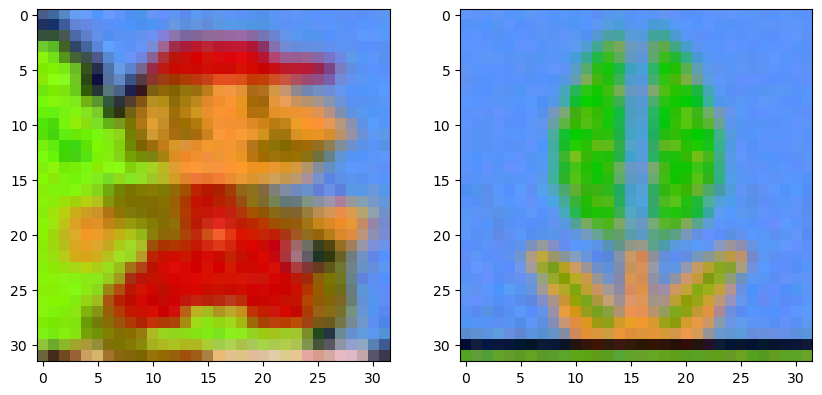

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(video_Shrinkage[0][:,:,:,:,350].reshape(3, 32, 32).transpose(1, 2, 0), cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(video_Shrinkage[0][:,:,:,:,400].reshape(3, 32, 32).transpose(1, 2, 0), cv2.COLOR_BGR2RGB))
plt.show()

In [31]:
def process_codes(codes):
    codes = codes.squeeze()
    pca = PCA(n_components=3)
    codes_new = np.zeros((codes.shape[-1], codes.shape[0] * codes.shape[1]))
    for i in range(codes.shape[-1]):
        codes_new[i, :] = codes[:,:,i].flatten()
    test = pca.fit_transform(codes_new)
    return test

In [32]:
def plot_codes(idx):
    # make a matplotlib subplots with one row and 4 columns, each figure has projection 3d
    fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': '3d'})
    # make a scatter plot for each figure
    pca = PCA(n_components=3)
    gap = 100
    colors = ['g', 'y', 'b', 'k', 'r']
    
    pca = PCA(n_components=3)
    test = pca.fit_transform(encode_list_ae[idx])
    for i in range(5):
        ax[0].scatter(test[i*gap:(i+1)*gap,0], test[i*gap:(i+1)*gap,1], test[i*gap:(i+1)*gap,2], c=colors[i], marker='o')

    test = pca.fit_transform(encode_list_WTA[idx])
    for i in range(5):
        ax[1].scatter(test[i*gap:(i+1)*gap,0], test[i*gap:(i+1)*gap,1], test[i*gap:(i+1)*gap,2], c=colors[i], marker='o')
    
    test = process_codes(encode_list_FISTA[idx])
    for i in range(5):
        ax[2].scatter(test[i*gap:(i+1)*gap,0], test[i*gap:(i+1)*gap,1], test[i*gap:(i+1)*gap,2], c=colors[i], marker='o')

    test = process_codes(encode_list_Shrinkage[idx])
    for i in range(5):
        ax[3].scatter(test[i*gap:(i+1)*gap,0], test[i*gap:(i+1)*gap,1], test[i*gap:(i+1)*gap,2], c=colors[i], marker='o')

    

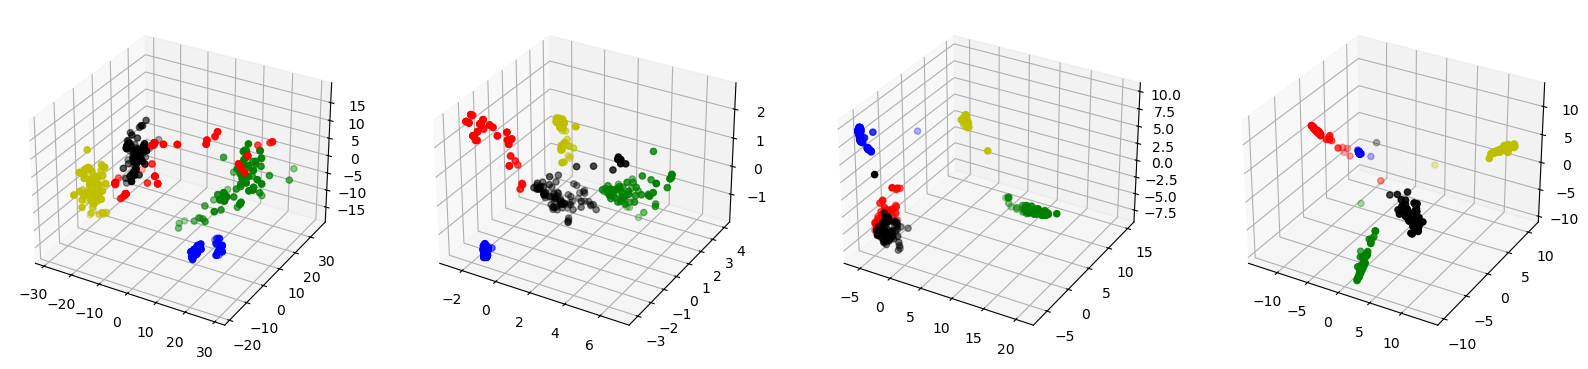

In [33]:
plot_codes(0)

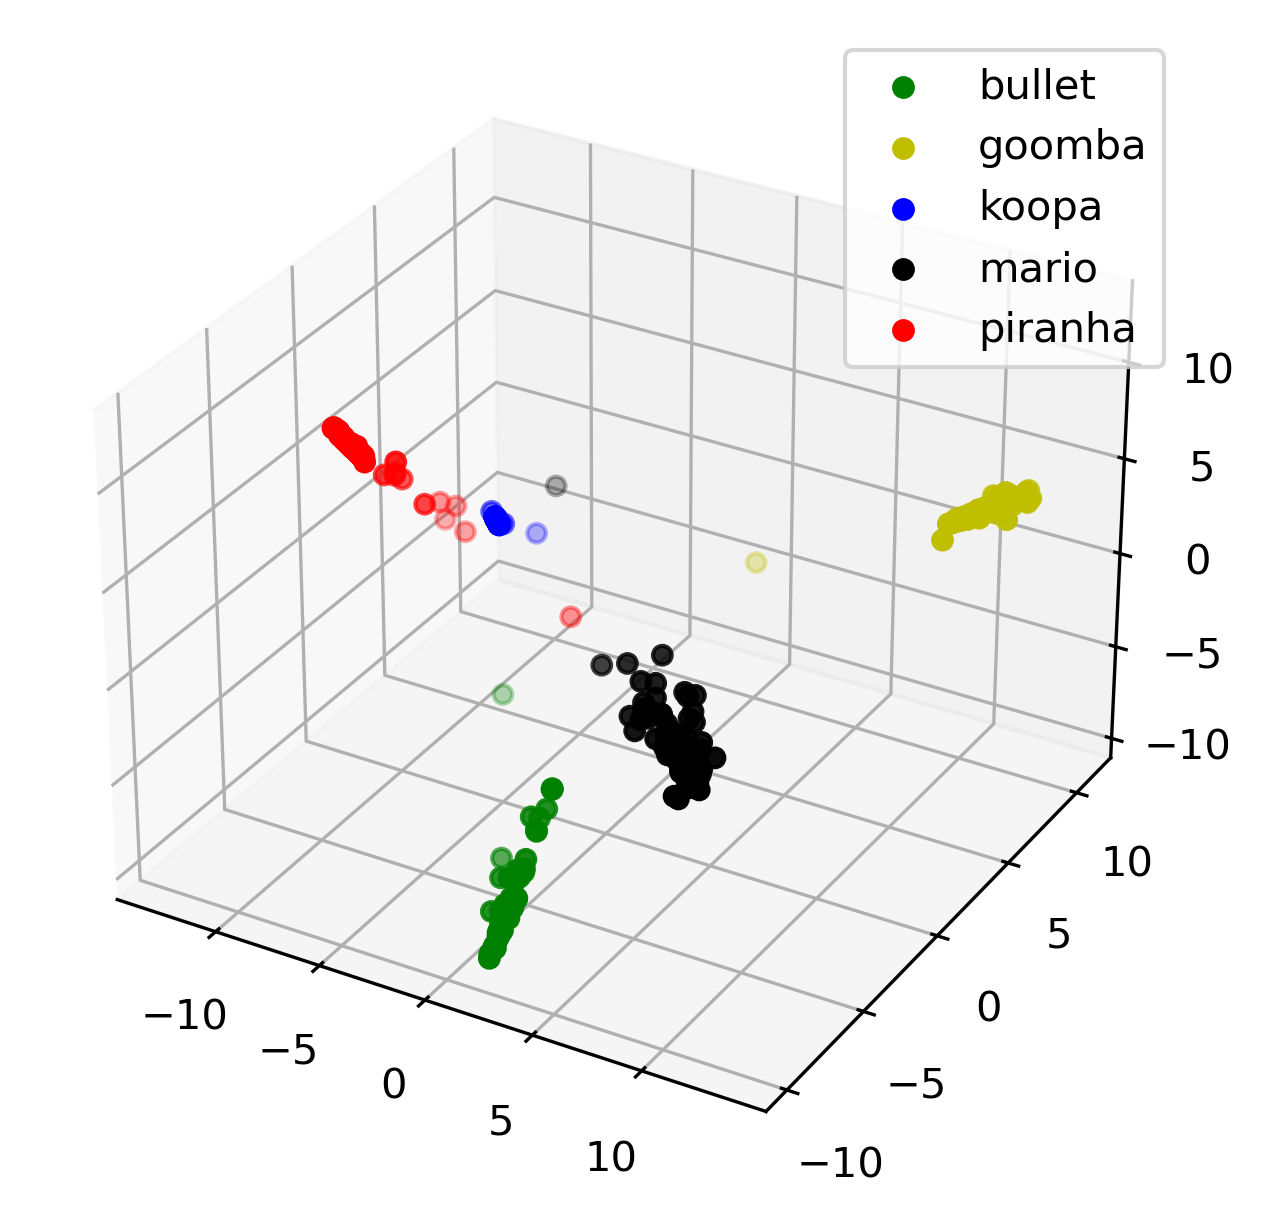

In [34]:
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': '3d'}, dpi=300)
gap = 100
pca = PCA(n_components=3)
test = process_codes(encode_list_Shrinkage[0])
colors = ['g', 'y', 'b', 'k', 'r']
labels = ["bullet", "goomba", "koopa", "mario", "piranha"]
for i in range(5):
    ax.scatter(test[i*gap:(i+1)*gap,0], test[i*gap:(i+1)*gap,1], test[i*gap:(i+1)*gap,2], c=colors[i], marker='o', label=labels[i])
    ax.legend()
    
plt.savefig('MM.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [35]:
print(encode_list_ae[0].shape)
print(encode_list_FISTA[0].shape)
print(encode_list_Shrinkage[0].shape)
print(encode_list_WTA[0].shape)

(500, 9)
(1, 3, 1, 40, 1, 500)
(1, 3, 1, 40, 1, 500)
(500, 64)


# Put all reconstructions together

In [72]:
import torchvision


In [43]:
print(video_ae[0].shape, video_WTA[0].shape, video_FISTA[0].shape, video_Shrinkage[0].shape)

(500, 1, 3072) (500, 1, 3072) (1, 3, 32, 32, 500) (1, 3, 32, 32, 500)


In [112]:
def get_sequence(video, gap, idx):
    img_list = []
    if len(video[idx].shape) < 4:
        img_list+=[torch.from_numpy(video[idx][0 + i*gap,:,:].reshape(3,32,32)) for i in range(3)]
        img_list+=[torch.from_numpy(video[idx][100 + i*gap,:,:].reshape(3,32,32)) for i in range(3)]
        img_list+=[torch.from_numpy(video[idx][200 + i*gap,:,:].reshape(3,32,32)) for i in range(3)]
        img_list+=[torch.from_numpy(video[idx][300 + i*gap,:,:].reshape(3,32,32)) for i in range(3)]
        img_list+=[torch.from_numpy(video[idx][400 + i*gap,:,:].reshape(3,32,32)) for i in range(3)]
    else:
        img_list+=[torch.from_numpy(video[idx][0, ..., 0 + i*gap].reshape(3,32,32)) for i in range(3)]
        img_list+=[torch.from_numpy(video[idx][0, ..., 100 + i*gap].reshape(3,32,32)) for i in range(3)]
        img_list+=[torch.from_numpy(video[idx][0, ..., 200 + i*gap].reshape(3,32,32)) for i in range(3)]
        img_list+=[torch.from_numpy(video[idx][0, ..., 300 + i*gap].reshape(3,32,32)) for i in range(3)]
        img_list+=[torch.from_numpy(video[idx][0, ..., 400 + i*gap].reshape(3,32,32)) for i in range(3)]
    images = torch.stack(img_list)
    images = torchvision.utils.make_grid(images, nrow=15, padding=5, pad_value=1)
    images = images.permute(1,2,0).numpy()
    images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    return images

In [116]:
images_AE = get_sequence(video_ae, 10, 3)
images_WTA = get_sequence(video_WTA, 10, 3)
images_FISTA = get_sequence(video_FISTA, 10, 3)
images_Shrinkage = get_sequence(video_Shrinkage, 10, 3)
images_gt = get_sequence(video_gt, 10, 3)

In [158]:
np.save('images_AE.npy', images_AE)
np.save('images_WTA.npy', images_WTA)
np.save('images_FISTA.npy', images_FISTA)
np.save('images_Shrinkage.npy', images_Shrinkage)
np.save('images_gt.npy', images_gt)

Text(0.105, 0.495, 'GT')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


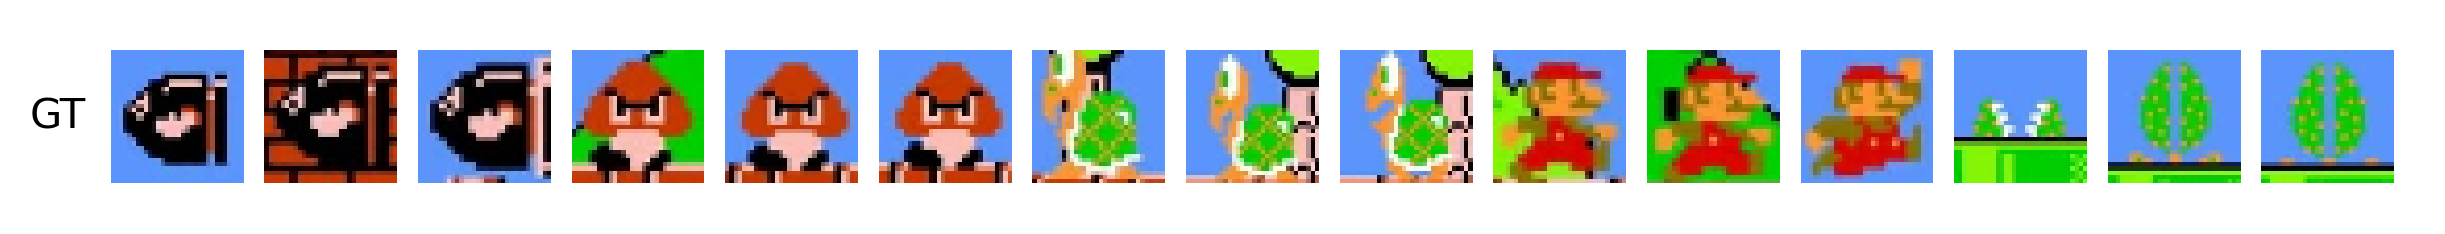

In [157]:
#plt.rcParams["font.serif"] = ["Times New Roman"]
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_gt)
#plt.ylabel('GT', fontsize=14)
plt.axis('off')
plt.text(0.105, 0.495, 'GT',
        horizontalalignment='left',
        verticalalignment='center',
        #rotation='vertical',
        transform=plt.gcf().transFigure,
        fontdict={'fontname': 'Times New Roman'})



# save the images
#plt.savefig('Mario_gt.pdf', format='pdf', dpi=300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


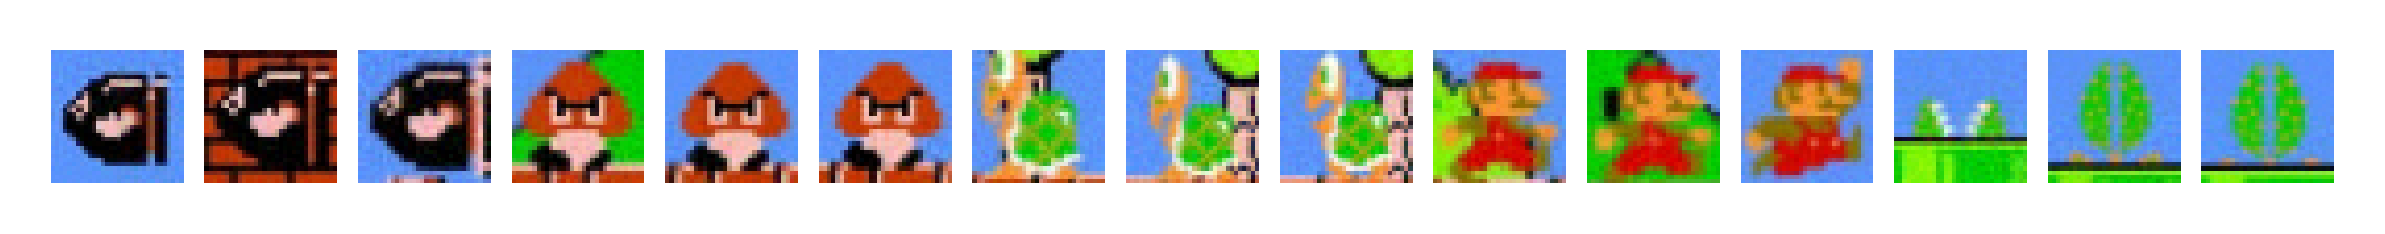

In [119]:
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_Shrinkage)
plt.axis('off')

# save the images
plt.savefig('Mario_MM.pdf', format='pdf', dpi=300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


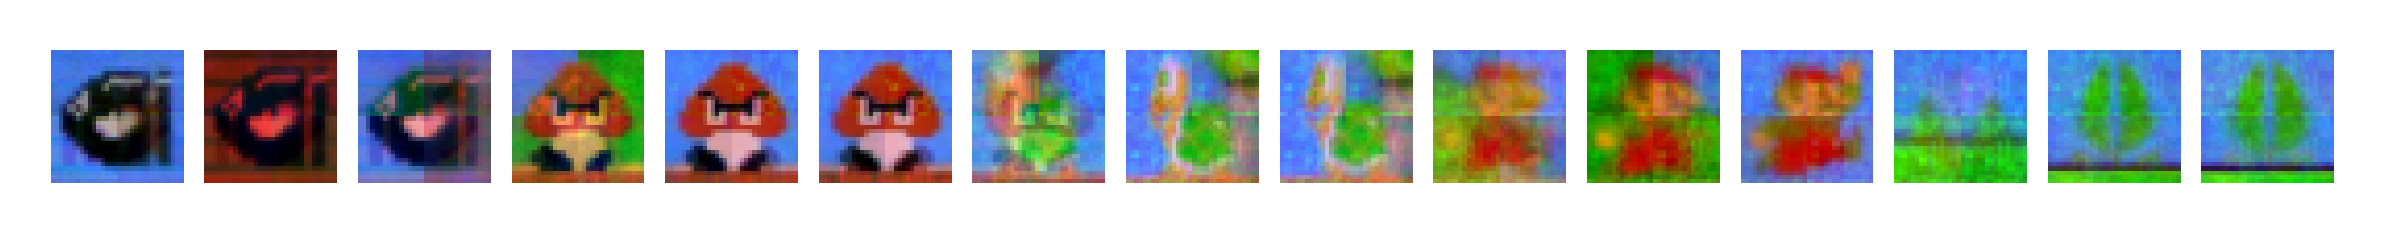

In [120]:
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_FISTA)
plt.axis('off')

# save the images
plt.savefig('Mario_FISTA.pdf', format='pdf', dpi=300, bbox_inches='tight')

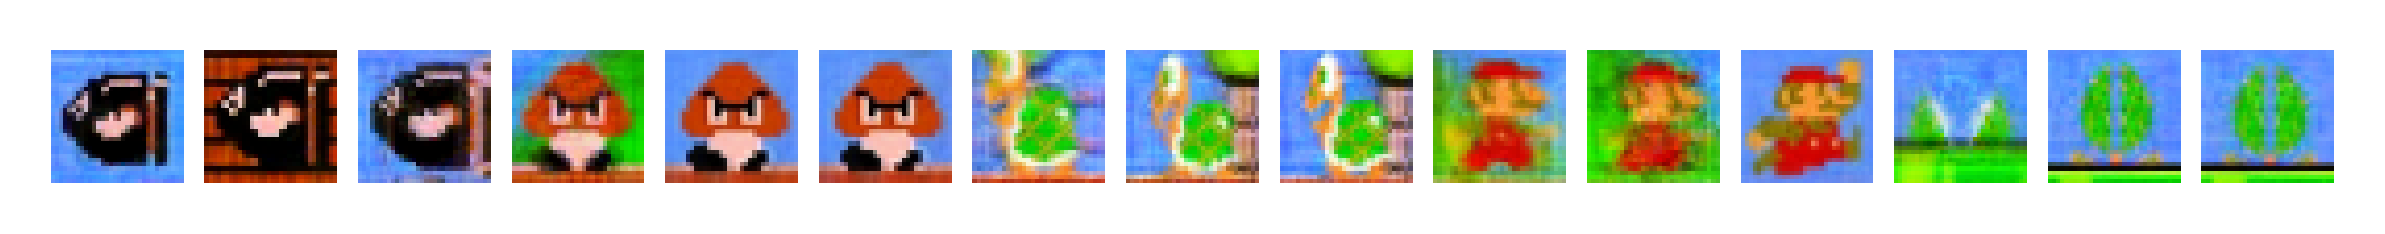

In [121]:
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_AE)
plt.axis('off')

# save the images
plt.savefig('Mario_AE.pdf', format='pdf', dpi=300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


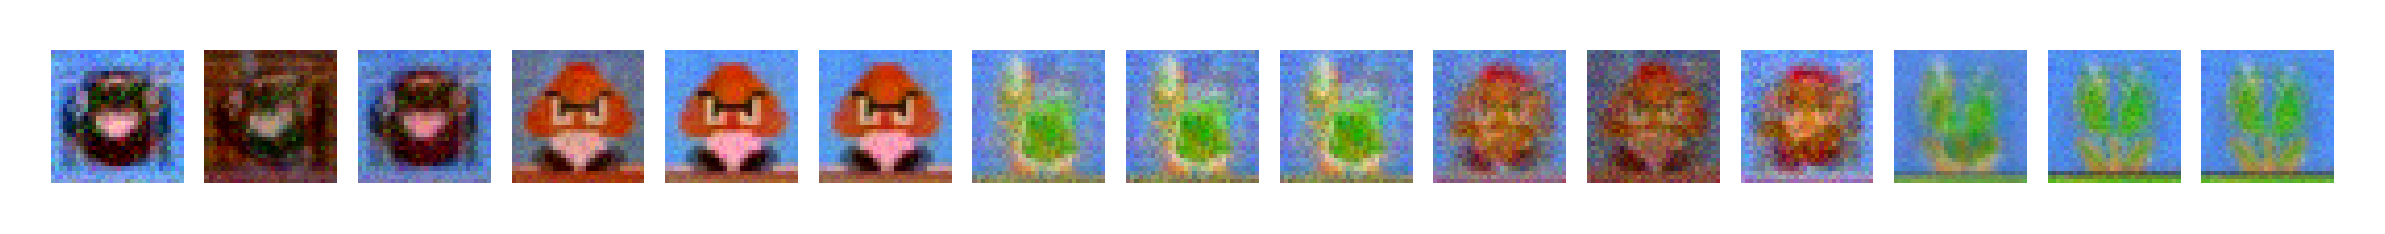

In [122]:
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_WTA)
plt.axis('off')

# save the images
plt.savefig('Mario_WTA.pdf', format='pdf', dpi=300, bbox_inches='tight')